In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import transitleastsquares as tls

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [278]:
srs = lk.search_lightcurve("WASP50", author="SPOC", exptime=120)
display(srs)
lcs = srs.download_all(flux_column="pdcsap_flux")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 31,2020,SPOC,120,382391899,0.0


In [279]:
def check_cols(lc):
    print(lc.flux[0], lc.pdcsap_flux[0] / np.median(lc.pdcsap_flux))

In [287]:
binsize = 0.5
lcs_binned = lk.LightCurveCollection(
    [
        data_oot(
            lc.remove_nans("flux").remove_nans("flux_err"),
            period, duration, t_0).flatten()
        .bin(
            time_bin_size=binsize,
        ).remove_nans("flux").remove_nans("flux_err").normalize()
        for lc in lcs
    ]
)

lcs_combined = lcs_binned.stitch().remove_nans()
lcs_combined.to_csv("/home/mango/Desktop/tess.csv", overwrite=True)

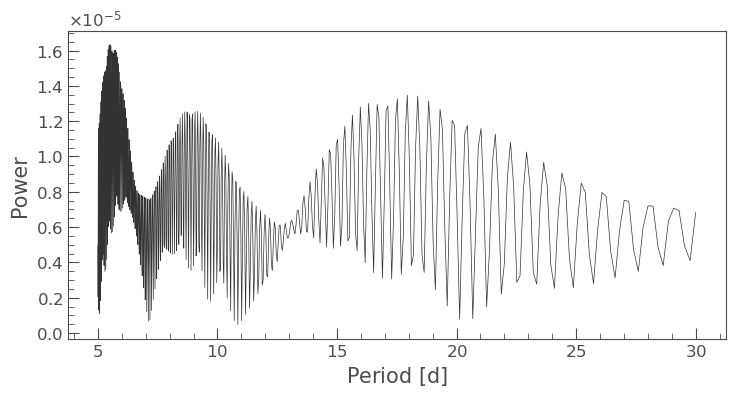

In [288]:
pg = lcs_combined.to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

plt.show()

In [ ]:
pg.period_at_max_power

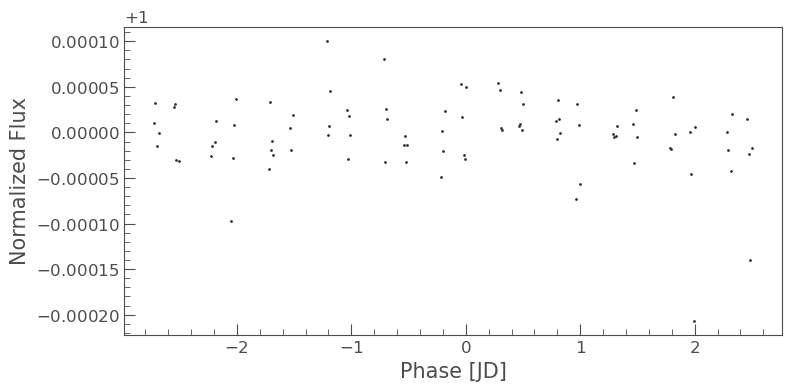

In [290]:
lcs_combined.fold(pg.period_at_max_power).scatter()

plt.show()

In [291]:
check_cols(lcs_binned[1])

0.9999998190704305 0.9996360238780622


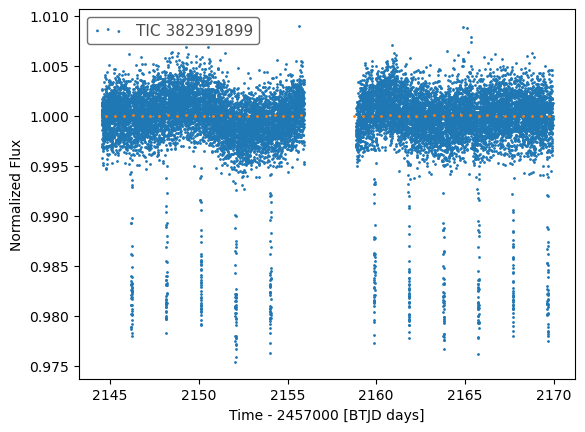

In [292]:
fig, ax = plt.subplots()

i = 1
lcs[i].normalize().scatter(ax=ax)
lcs_binned[i].scatter(ax=ax)


fig

In [293]:
srs_tpfs = lk.search_targetpixelfile("WASP50", exptime=[120, 1800])
display(srs_tpfs)
tpfs = srs_tpfs.download_all()

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
2,TESS Sector 31,2020,SPOC,120,382391899,0.0
3,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


In [294]:
from astropy.time import Time

In [295]:
P = 1.9550931258
t_0 = 2455558.61237
dur = 1.83 * (1.0 / 24.0)

lit_period = 1.955093
lit_transit_time = Time(2459169.669461, format='jd')
lit_duration = 1.8336 / 24.

In [296]:
def oot_flux(lc, P, t_0, dur):
    in_transit = lc.create_transit_mask(P, t_0, dur)
    lc_oot = lc[~in_transit]
    return lc_oot

In [297]:
P - lit_period, t_0 - lit_transit_time.value, dur - lit_duration

(1.2579999997264224e-07, -3611.0570909995586, -0.00014999999999999736)

In [298]:
lc.time

<Time object: scale='tdb' format='btjd' value=[2144.51990041 2144.52128933 2144.52267824 ... 2169.946087   2169.94747585
 2169.94886469]>

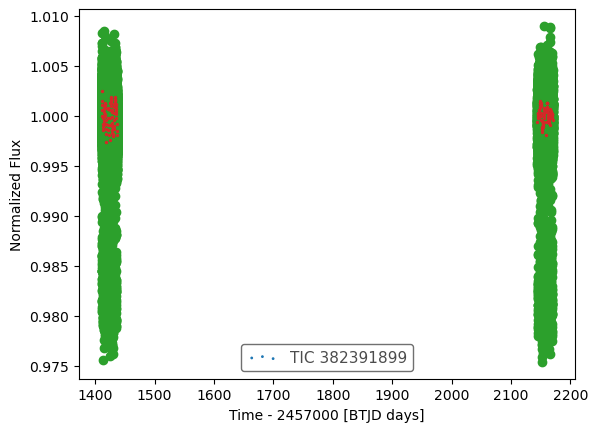

5.643122676579912 d


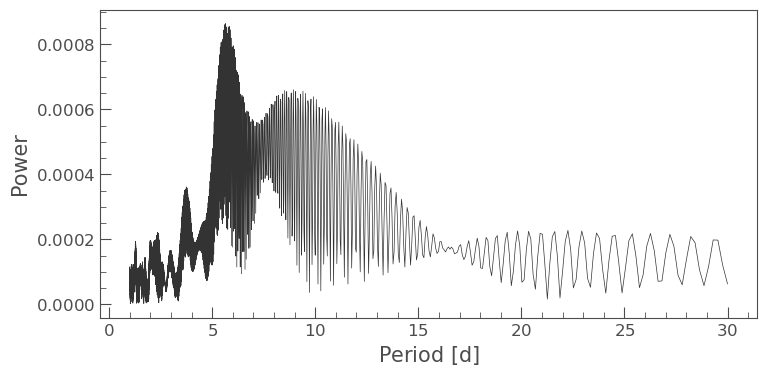

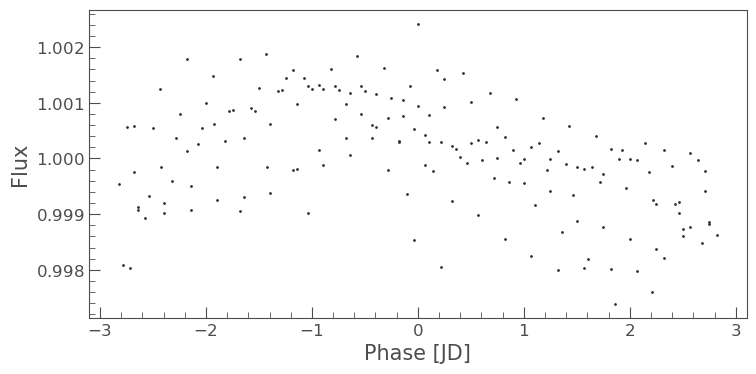

In [299]:
lc = lcs.stitch().remove_nans()#.normalize()
#lc_oot = oot_flux(lc, P, t_0, dur)

#mask = lc.create_transit_mask(lit_period, lit_transit_time, lit_duration)
mask = lc.create_transit_mask(P, Time(t_0, format="jd"), dur)
lc_oot = lc[~mask].bin(0.25)

plt.scatter(lc.time.value, lc.flux)
plt.scatter(lc_oot.time.value, lc_oot.flux.value, s=2)

plt.show()

pg = lc_oot.to_periodogram(minimum_period=1, maximum_period=30)
pg.plot()
P_max = pg.period_at_max_power
print(P_max)
plt.show()

lc_oot.fold(P_max).scatter()
plt.show()

In [300]:
np.allclose(y, y)

True

In [301]:
for lc in lcs:
    print(np.allclose(lc.flux.value, lc.flux.value))

False
False


In [302]:
np.allclose(lcs[1].flux.value, lc.flux.value)

False

In [303]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2144.5199004149786,6.2000854e+03,1.1389271e+01,5.0894548e-03,660283,1418.73484,657.38486,5.6992607e+03,9.9776764e+00,1.4246628e+03,3.9683039e+00,6.2000854e+03,1.1389271e+01,0,nan,nan,nan,nan,1418.73484,1.3279996e-03,657.38486,1.3848636e-03,1.7929811e-02,-2.2017066e-01
2144.5212893293296,6.2015508e+03,1.1374669e+01,5.0894809e-03,660284,1418.73929,657.38640,5.6992432e+03,9.9648857e+00,1.4214608e+03,3.9496894e+00,6.2015508e+03,1.1374669e+01,0,nan,nan,nan,nan,1418.73929,1.3252499e-03,657.38640,1.3835422e-03,2.4449093e-02,-2.1900417e-01
2144.52267824368,6.2031211e+03,1.1385294e+01,5.0895070e-03,660285,1418.73444,657.38402,5.7026606e+03,9.9741936e+00,1.4294525e+03,3.9600558e+00,6.2031211e+03,1.1385294e+01,0,nan,nan,nan,nan,1418.73444,1.3248657e-03,657.38402,1.3834382e-03,2.2294849e-02,-2.2108950e-01
2144.52406715803,6.2050293e+03,1.1380916e+01,5.0895330e-03,660286,1418.73715,657.38508,5.7033662e+03,9.9703569e+00,1.4242020e+03,3.9543047e+00,6.2050293e+03,1.1380916e+01,0,nan,nan,nan,nan,1418.73715,1.3256720e-03,657.38508,1.3812773e-03,2.1887753e-02,-2.2018403e-01
2144.5254560723815,6.2054741e+03,1.1382564e+01,5.0895591e-03,660287,1418.73661,657.38664,5.7055088e+03,9.9718018e+00,1.4200210e+03,3.9557126e+00,6.2054741e+03,1.1382564e+01,0,nan,nan,nan,nan,1418.73661,1.3208711e-03,657.38664,1.3829160e-03,2.0650476e-02,-2.1897879e-01
2144.526844986733,6.2017241e+03,1.1378417e+01,5.0895852e-03,660288,1418.73916,657.38560,5.6998994e+03,9.9681683e+00,1.4225905e+03,3.9578853e+00,6.2017241e+03,1.1378417e+01,0,nan,nan,nan,nan,1418.73916,1.3252265e-03,657.38560,1.3814402e-03,2.4788335e-02,-2.2116612e-01
2144.5282339010832,6.2052529e+03,1.1378769e+01,5.0896113e-03,660289,1418.73607,657.38729,5.7047949e+03,9.9684772e+00,1.4146035e+03,3.9557562e+00,6.2052529e+03,1.1378769e+01,0,nan,nan,nan,nan,1418.73607,1.3232755e-03,657.38729,1.3823499e-03,2.2514367e-02,-2.1854413e-01
2144.5296228154343,6.2074980e+03,1.1384020e+01,5.0896374e-03,660290,1418.73657,657.38435,5.7069814e+03,9.9730768e+00,1.4229421e+03,3.9546373e+00,6.2074980e+03,1.1384020e+01,0,nan,nan,nan,nan,1418.73657,1.3259043e-03,657.38435,1.3813369e-03,2.3177307e-02,-2.2065569e-01


In [304]:
lcs[0]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1410.907697206209,6.2585239e+03,1.1557840e+01,5.0703231e-03,132082,2023.38207,671.63645,5.5623047e+03,9.8813648e+00,1.3285054e+03,3.6023982e+00,6.2585239e+03,1.1557840e+01,0,nan,nan,nan,nan,2023.38207,1.3730535e-03,671.63645,1.3222167e-03,1.7119116e-01,-7.4971467e-02
1410.909086125265,6.2618818e+03,1.1560862e+01,5.0703539e-03,132083,2023.38158,671.63679,5.5648628e+03,9.8839474e+00,1.3226848e+03,3.6078129e+00,6.2618818e+03,1.1560862e+01,0,nan,nan,nan,nan,2023.38158,1.3729050e-03,671.63679,1.3212519e-03,1.7052230e-01,-7.5365342e-02
1410.9104750443212,6.2734663e+03,1.1561573e+01,5.0703846e-03,132084,2023.38162,671.63911,5.5744697e+03,9.8845558e+00,1.3216846e+03,3.6024897e+00,6.2734663e+03,1.1561573e+01,0,nan,nan,nan,nan,2023.38162,1.3705732e-03,671.63911,1.3218751e-03,1.7002426e-01,-7.2002925e-02
1410.9118639633766,6.2620503e+03,1.1560617e+01,5.0704153e-03,132085,2023.38511,671.63758,5.5652754e+03,9.8837395e+00,1.3176370e+03,3.6008630e+00,6.2620503e+03,1.1560617e+01,0,nan,nan,nan,nan,2023.38511,1.3725566e-03,671.63758,1.3242735e-03,1.7370598e-01,-7.5171642e-02
1410.9132528828977,6.2437910e+03,1.1543425e+01,5.0704465e-03,132086,2023.38463,671.64091,5.5491709e+03,9.8690395e+00,1.3236282e+03,3.5999038e+00,6.2437910e+03,1.1543425e+01,0,nan,nan,nan,nan,2023.38463,1.3740722e-03,671.64091,1.3251014e-03,1.7175424e-01,-7.0966899e-02
1410.9146418019538,6.2402651e+03,1.1548466e+01,5.0704773e-03,132087,2023.37978,671.64273,5.5482959e+03,9.8733501e+00,1.3276760e+03,3.6044683e+00,6.2402651e+03,1.1548466e+01,0,nan,nan,nan,nan,2023.37978,1.3764959e-03,671.64273,1.3247959e-03,1.6930321e-01,-6.6933408e-02
1410.91603072101,6.2718350e+03,1.1560477e+01,5.0705080e-03,132088,2023.38522,671.63449,5.5719609e+03,9.8836193e+00,1.3223142e+03,3.6069922e+00,6.2718350e+03,1.1560477e+01,0,nan,nan,nan,nan,2023.38522,1.3712582e-03,671.63449,1.3230841e-03,1.7464249e-01,-7.6113977e-02
1410.9174196400654,6.2675566e+03,1.1555481e+01,5.0705387e-03,132089,2023.38215,671.63953,5.5690479e+03,9.8793468e+00,1.3215554e+03,3.5928783e+00,6.2675566e+03,1.1555481e+01,0,nan,nan,nan,nan,2023.38215,1.3702476e-03,671.63953,1.3209442e-03,1.7185172e-01,-7.0966110e-02


In [305]:
np.allt(lc.flux.value == lc.flux.value)

AttributeError: module 'numpy' has no attribute 'allt'

In [306]:
lcs_binned[0][1:3]

time,flux,flux_err,time_bin_start,time_bin_size,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float64,float64,object,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1411.657697206209,1.0000313214011296,9.752420886428014e-05,1411.407697206209,43200.0,0.005085851065814495,132622,2023.3843267252414,671.6425541263101,5547.6005859375,9.869446754455566,1318.8992919921875,3.59892201423645,6256.2255859375,11.543898582458496,0,nan,nan,nan,nan,2023.3843267252414,0.0013751732185482979,671.6425541263101,0.0013265988091006875,0.17477408051490784,-0.0667853131890297
1412.157697206209,0.9999437102283999,9.969001681902561e-05,1411.907697206209,43200.0,0.00509495846927166,132977,2023.3843443078213,671.6446073039305,5545.796875,9.868013381958008,1318.02099609375,3.598435640335083,6251.24365234375,11.542223930358887,0,nan,nan,nan,nan,2023.3843443078213,0.0013752812519669533,671.6446073039305,0.0013256262755021453,0.17479637265205383,-0.06355922669172287


/home/mango/miniconda3/envs/WASP-50b/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


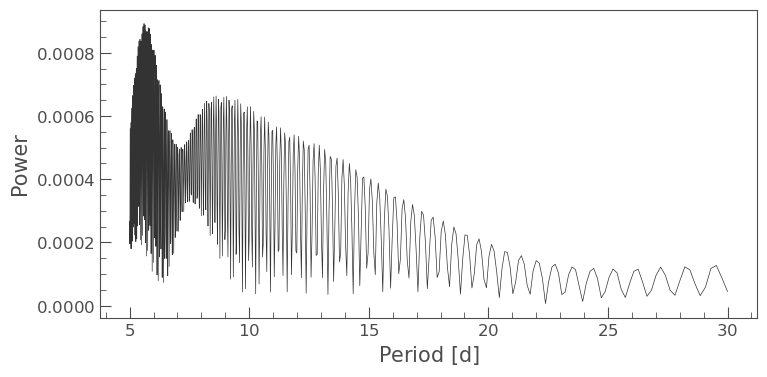

In [307]:
pg = lcs.stitch().normalize().bin(0.05).to_periodogram(minimum_period=5, maximum_period=30)
pg.plot()
plt.show()

Running pixels in aperture: 100%|██████████| 200/200 [00:00<00:00, 411.22it/s]


16.00536193029491


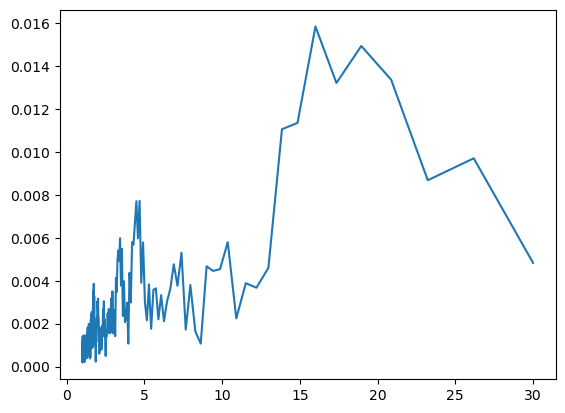

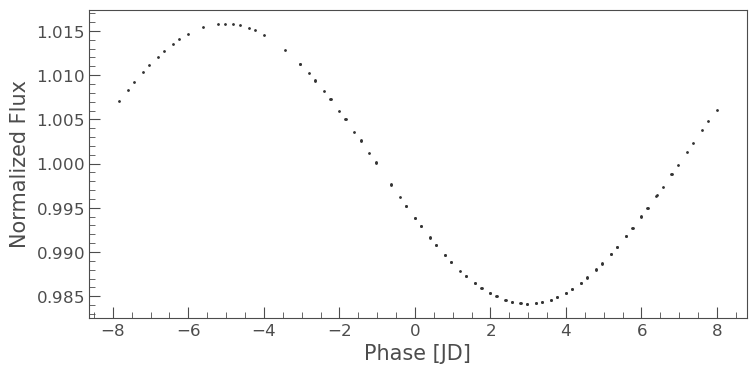

In [311]:
binsize = 0.4
lcs_binned = lk.LightCurveCollection(
    [lcs[0].bin(binsize), lcs[1].bin(binsize)]
)

sip_kwargs = {
    "min_period": 1.0,
    "max_period": 30.0,
    "nperiods": 200,
    #"bin_kwargs": {"time_bin_size": 12.0*u.hr.to("d")},
}

r = SIP(lcs_binned, **sip_kwargs)

l_corr = data_oot(r["corr_lc"], period, duration, t_0)

P_max = r["period_at_max_power"]
#P_max = r["periods"][np.argmax(p_div)]
#p_div = r["power"]/r["power_bkg"]
p_div = r["power"]

plt.plot(r["periods"], p_div)
#plt.axvline(P_max, "r--")

print(P_max)

l_corr.fold(P_max).scatter()

plt.show()

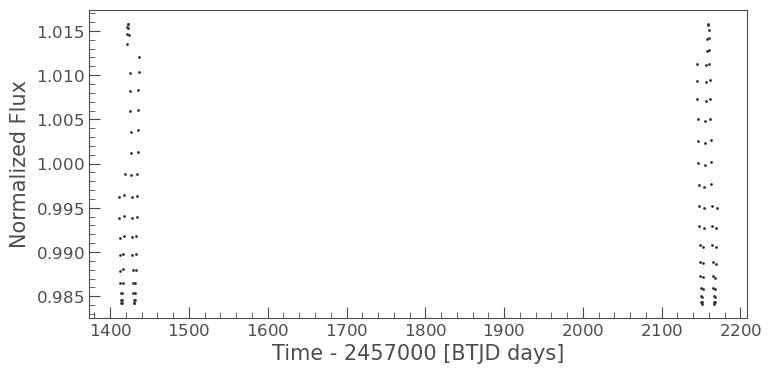

In [312]:
r["corr_lc"].scatter()
plt.show()

In [78]:
r["corr_lc"].to_csv("/home/mango/Desktop/tess.csv")

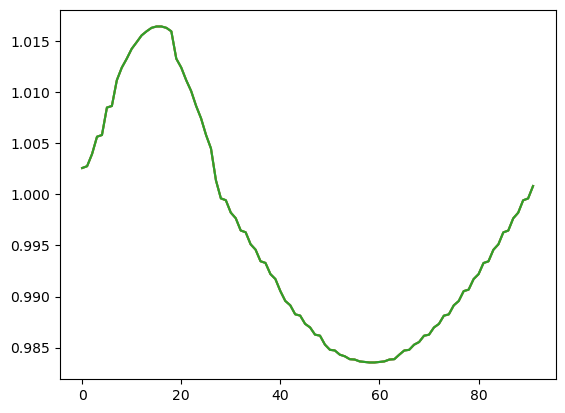

In [84]:
f = l_corr.fold(P_max).flux.value

np.median

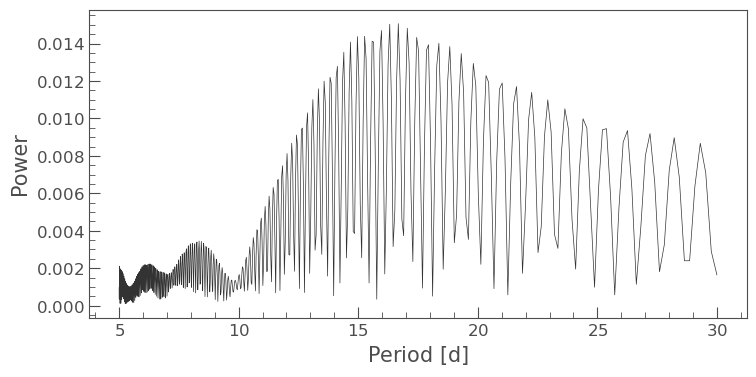

In [76]:
pg = r["corr_lc"].to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

plt.show()

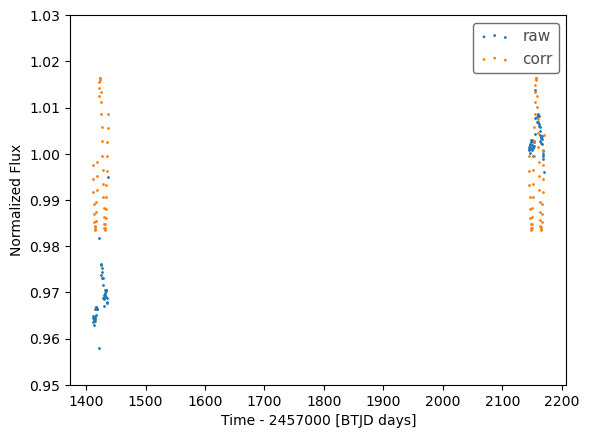

In [71]:
fig, ax = plt.subplots()

#data_oot(lcs.stitch(), period, duration, t_0).scatter(ax=ax, label="raw")
#data_oot(l_corr, period, duration, t_0).scatter(ax=ax, label="corrected")

#plt.xlim(1400, 1450)
#plt.xlim(2100, 2200)

r["raw_lc"].scatter(ax=ax, label="raw")
r["corr_lc"].scatter(ax=ax, label="corr")

#ax.set_xlim(1400, 1450)
ax.set_ylim(0.95, 1.03)

plt.show()

In [4]:
period = 1.9550931258
t_0 = 2455558.61237 
duration = 1.1 * 1.83 * (1.0 / 24.0) # 1.1x buffer

def data_oot(lc, period, duration, t_0):
    in_transit = tls.transit_mask(lc.time.jd, period, duration, t_0)
    return lc[~in_transit]

In [5]:
import pandas as pd

In [ ]:
lcs_binned.stitch().to_csv("/home/mango/Desktop/tess.csv", overwrite=True)

In [39]:
pg = lc.to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

P_max = pg.period_at_max_power
print(P_max)

plt.show()

NameError: name 'lc' is not defined

In [ ]:
pg._LS_object.false_alarm_probability(0.0014, method="davies")

In [ ]:
pg._LS_object.false_alarm_probability(0.0014)

In [ ]:
fig, ax = plt.subplots()

lc_folded = lc.fold(P_max)#.remove_outliers(sigma=3)

lc_folded.scatter(ax=ax)
#lc_folded.bin(0.2).scatter(ax=ax, marker="x")

#plt.ylim(0.995, 1.005)

plt.show()